# Importeer Libraries

Starten doen we door de nodige libraries te importeren.

In [32]:
!pip install -r ../requirements.txt

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import sklearn
import os

# Download en importeer data bestanden

We beginnen met eerst de nodige data in te laden.

In [4]:
os.listdir("../data")

['.DS_Store', 'station_data.csv', 'weather_data.csv', 'trip_data.csv']

We hebben 3 bestanden aan data beschikbaar, we laden ze in en bekijken eerst naar de data die ze bevatten.

## Station data

In [5]:
station_data = pd.read_csv("../data/station_data.csv")
station_data.head()

,Id,Name,Lat,Long,Dock Count,City
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose


Elk station bevat verschillende gegevens:
- id: een unieke getal voor elk station
- Name: Naam van het station
- Lat: breedtegraad
- Long: lengtegraad
- Dock count: aantal plaatsen voor fietsen in het station
- City: De stad waar het station zich bevind

In [6]:
column_types = station_data.dtypes
print(column_types)

Id              int64
Name           object
Lat           float64
Long          float64
Dock Count      int64
City           object
dtype: object


Het type object betekent string in dit geval. Alle kolommen staan reeds in de juiste vorm.

In [7]:
station_data['City'].value_counts()

City
San Francisco    39
San Jose         16
Redwood City      9
Mountain View     7
Palo Alto         5
Name: count, dtype: int64

In [8]:
station_data.groupby(['City'])['Dock Count'].sum()

City
Mountain View    117
Palo Alto         75
Redwood City     145
San Francisco    753
San Jose         264
Name: Dock Count, dtype: int64

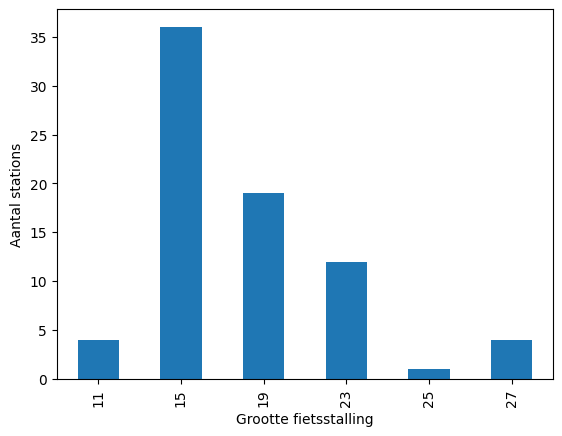

In [9]:
station_data['Dock Count'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Grootte fietsstalling')        
plt.ylabel('Aantal stations')
plt.show()

We zien hier dat elk station tussen de 11 en 27 plaatsen voor fietsen bevatten, en het grootste aantal stations plaats voor 15 fietsen heeft.

## Trip data

In [10]:
trip_data = pd.read_csv("../data/trip_data.csv")
trip_data.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type
0,891070,14/08/2015 23:49,82,14/08/2015 23:55,42,Subscriber
1,891069,14/08/2015 23:49,82,14/08/2015 23:58,87,Subscriber
2,891068,14/08/2015 23:49,60,14/08/2015 23:54,74,Subscriber
3,891067,14/08/2015 23:48,59,14/08/2015 23:51,59,Subscriber
4,891066,14/08/2015 23:38,28,14/08/2015 23:53,27,Subscriber


Elke trip die een persoon maakt bevat de volgende gegevens:
- Trip ID: een uniek number voor elke trip
- Start Date: start tijd en datum van de trip
- Start Station: Waar is de trip begonnen
- End Date: eind tijd en datum van de trip
- End Station: Waar is de trip beëindigd
- Subscriber Type: Wat soort abbonement heeft de gebruiker

In [11]:
column_types = trip_data.dtypes
print(column_types)

Trip ID             int64
Start Date         object
Start Station       int64
End Date           object
End Station         int64
Subscriber Type    object
dtype: object


Hier zien we dat de start en eind tijd in string formaat staan. Hierdoor kunnen we niet redeneren over tijd, wat een belangrijk aspect is voor het voorspellen van het aantal fietsen. We moeten deze dus eerst transformeren.

In [12]:
trip_data['Start Date'] = pd.to_datetime(trip_data['Start Date'], format='%d/%m/%Y %H:%M')
trip_data['End Date'] = pd.to_datetime(trip_data['End Date'], format='%d/%m/%Y %H:%M')
print(trip_data.dtypes)

Trip ID                     int64
Start Date         datetime64[ns]
Start Station               int64
End Date           datetime64[ns]
End Station                 int64
Subscriber Type            object
dtype: object


In [13]:
trip_data['Start Date'].min()

Timestamp('2014-09-01 00:05:00')

In [18]:
trip_data['Start Date'].max()

Timestamp('2015-08-14 23:49:00')

In [30]:
allRoutes = trip_data.groupby(['Start Station','End Station']).size().reset_index(name='trip_count')
popularRoutes = allRoutes.sort_values(by='trip_count', ascending=False).head(10)
popularRoutes

,Start Station,End Station,trip_count
741,50,60,2988
1085,61,50,2836
742,50,61,2524
790,51,70,2313
1596,74,61,2225
1068,60,74,2175
1259,65,70,2167
868,55,70,2070
1435,70,50,1992
1410,69,65,1988


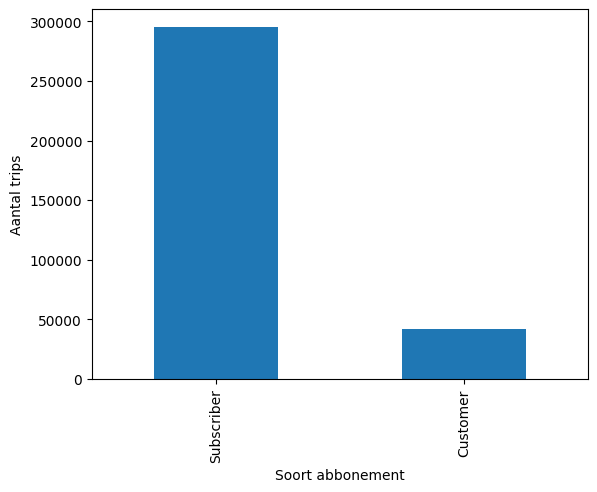

In [14]:
trip_data['Subscriber Type'].value_counts().plot(kind='bar')
plt.xlabel('Soort abbonement')        
plt.ylabel('Aantal trips')
plt.show()

## Weer data

In [15]:
station_data = pd.read_csv("../data/weather_data.csv")
station_data.head(10)

,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Zip
0,01/09/2014,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,...,10.0,8.0,16.0,7.0,20.0,0.0,0.0,NaN,290.0,94107
1,02/09/2014,72.0,66.0,60.0,58.0,57.0,55.0,84.0,73.0,61.0,...,10.0,7.0,21.0,8.0,NaN,0.0,5.0,NaN,290.0,94107
2,03/09/2014,76.0,69.0,61.0,57.0,56.0,55.0,84.0,69.0,53.0,...,10.0,10.0,21.0,8.0,24.0,0.0,4.0,NaN,276.0,94107
3,04/09/2014,74.0,68.0,61.0,57.0,57.0,56.0,84.0,71.0,57.0,...,10.0,8.0,22.0,8.0,25.0,0.0,5.0,NaN,301.0,94107
4,05/09/2014,72.0,66.0,60.0,57.0,56.0,54.0,84.0,71.0,57.0,...,9.0,7.0,18.0,8.0,32.0,0.0,4.0,NaN,309.0,94107
5,06/09/2014,72.0,66.0,60.0,55.0,54.0,52.0,84.0,69.0,53.0,...,9.0,7.0,17.0,9.0,30.0,0.0,4.0,NaN,290.0,94107
6,07/09/2014,72.0,66.0,60.0,54.0,53.0,45.0,78.0,66.0,53.0,...,10.0,10.0,18.0,10.0,28.0,0.0,3.0,NaN,293.0,94107
7,08/09/2014,68.0,64.0,59.0,52.0,51.0,50.0,72.0,64.0,55.0,...,10.0,10.0,18.0,12.0,22.0,0.0,4.0,NaN,272.0,94107
8,09/09/2014,72.0,65.0,57.0,56.0,53.0,52.0,87.0,72.0,57.0,...,10.0,10.0,17.0,7.0,21.0,0.0,5.0,NaN,270.0,94107
9,10/09/2014,82.0,68.0,54.0,59.0,56.0,51.0,93.0,66.0,39.0,...,9.0,5.0,16.0,5.0,20.0,0.0,1.0,NaN,283.0,94107


In [16]:
station_data.describe()

,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressureIn,...,Max VisibilityMiles,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,WindDirDegrees,Zip
count,1804.000000,1804.000000,1804.000000,1758.000000,1758.000000,1758.000000,1758.000000,1758.000000,1758.000000,1807.000000,...,1803.000000,1803.000000,1803.000000,1807.000000,1807.000000,1267.000000,1807.000000,1807.000000,1807.000000,1808.000000
mean,70.513304,61.734479,52.654102,54.403868,50.337884,46.079067,87.515927,69.345848,48.866325,30.071500,...,10.480311,9.640044,7.949529,16.334256,6.143885,21.682715,0.025267,3.109020,260.316547,94317.590708
std,8.171440,6.831618,7.019431,6.330548,7.106127,8.556086,8.570145,10.414072,14.246301,0.135663,...,2.092751,1.437061,3.000777,8.625663,3.250742,6.075386,0.178028,2.305024,96.286524,399.252385
min,50.000000,41.000000,30.000000,20.000000,13.000000,4.000000,25.000000,25.000000,4.000000,29.670000,...,5.000000,4.000000,0.000000,4.000000,0.000000,7.000000,0.000000,0.000000,0.000000,94041.000000
25%,64.000000,57.000000,48.000000,50.000000,47.000000,41.000000,83.000000,64.000000,40.000000,29.970000,...,10.000000,10.000000,7.000000,12.000000,4.000000,18.000000,0.000000,1.000000,241.000000,94063.000000
50%,70.000000,61.000000,53.000000,55.000000,51.000000,47.000000,88.000000,70.000000,50.000000,30.060000,...,10.000000,10.000000,10.000000,16.000000,6.000000,22.000000,0.000000,3.000000,295.000000,94107.000000
75%,76.000000,67.000000,58.000000,59.000000,56.000000,53.000000,93.000000,75.000000,57.000000,30.170000,...,10.000000,10.000000,10.000000,20.000000,8.000000,25.000000,0.000000,5.000000,329.000000,94301.000000
max,102.000000,82.000000,75.000000,68.000000,64.000000,63.000000,100.000000,96.000000,86.000000,30.480000,...,20.000000,20.000000,20.000000,128.000000,23.000000,62.000000,3.360000,8.000000,360.000000,95113.000000
